In [1]:
#@title File Locations
base_dir = "" #@param {type:"string"}
state_param_file = "data/us-wa/wa_state_parameters_transpose.csv" #@param {type:"string"}
county_households_file = "data/us-wa/wa_county_household_demographics.csv" #@param {type:"string"}
county_params_file = "data/us-wa/wa_county_parameters.csv" #@param {type:"string"}
county_occupation_file = "data/us-wa/wa_county_occupation_networks.csv"  #@param {type:"string"}
import os
if base_dir:
  state_param_file = os.path.join(base_dir, state_param_file)
  county_households_file = os.path.join(base_dir, county_households_file)
  county_params_file = os.path.join(base_dir, county_params_file)
  county_occupation_file = os.path.join(base_dir, county_occupation_file)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport county_utils

In [47]:
from county_utils import AggregateModel
import numpy as np
import pandas as pd

In [4]:
local_params = {
    "lockdown_days": 35,
    "app_turned_on": 1,
    "custom_occupation_network": 1,
}

In [5]:
model = AggregateModel([state_param_file], county_households_file, county_occupation_file, county_params_file, local_params)

In [42]:
results = model.run_counties(model.counties[:1])

Batch progress: 100%|██████████| 1/1 [00:17<00:00, 17.87s/it]


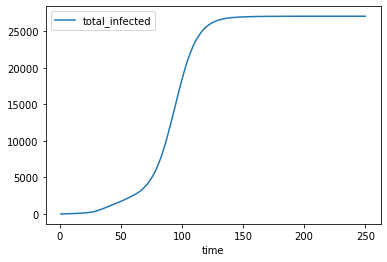

In [43]:
list(results.values())[0][1].plot(x='time', y='total_infected')

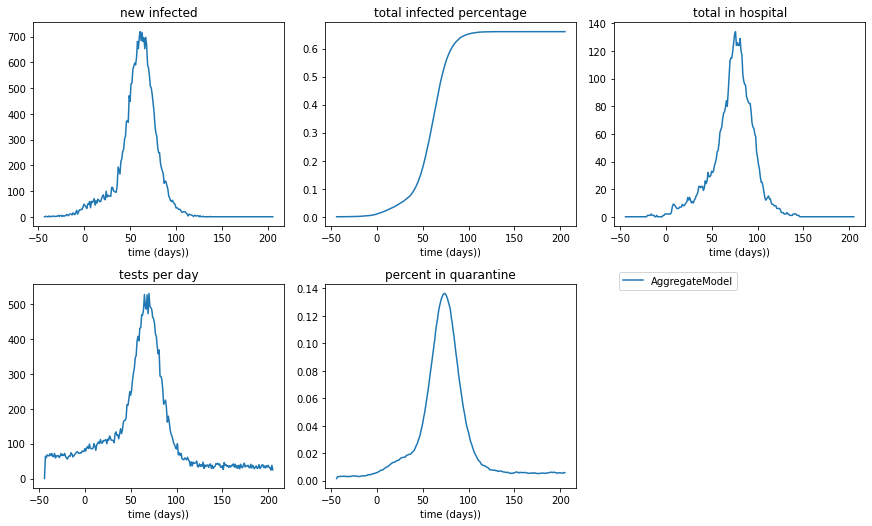

In [40]:
model.plot_results()

In [44]:
results_no_custom_occu = model.run_county(model.counties[0], {"custom_occupation_network": 0})

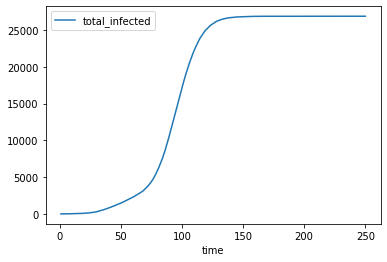

In [45]:
results_no_custom_occu[1].plot(x='time', y='total_infected')

In [49]:
np.where(list(results.values())[0][1].lockdown == 1), np.where(results_no_custom_occu[1].lockdown == 1)

((array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
         65]),),
 (array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
         67]),))